In [1]:
import numpy as np
from scipy.special import p_roots
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
from numpy.linalg import inv

In [2]:
def gauss_quadrature(n,a,b):
    # Compute the points and weights for the Gaussian quadrature rule
    x, w = p_roots(n) #n代表切幾塊
    #print(x) #點的位置
    #print(w) #權重
    # Scale the points and weights to the interval [a, b]
    x_scaled = (b - a) / 2 * x + (a + b) / 2 #邊界[-1,1]所以x_scaled=x
    w_scaled = (b - a) / 2 * w #邊界[-1,1]所以w_scaled=w
    #print(x_scaled)
    #print(w_scaled)
    # Evaluate the function at the quadrature points and sum the results
    #integral = np.sum(w_scaled * f(x_scaled))

    return x,w

In [3]:
from scipy.integrate import quad
#測試高斯積分
# 定義要積分的函數
def f(x):
    return x ** 2

# 計算從-1到1的定積分
result, error = quad(f, -1, 1)
xx,ww=gauss_quadrature(4,-1,1)
print([xx,ww])
integral = np.sum(ww * f(xx))
print(result)  # 輸出解析解積分結果
#print(error)
print(integral) #輸出高斯積分輸出結果

[array([-0.86113631, -0.33998104,  0.33998104,  0.86113631]), array([0.34785485, 0.65214515, 0.65214515, 0.34785485])]
0.6666666666666666
0.6666666666666666


In [4]:
def function(N_element):
    x0=0
    xf=np.pi/2
    L=xf-x0
    N_node=N_element+1 #節點數
    L_element=L/N_element #每個omega的長度
    AE=1/5
    DOF=1
    return N_node,N_element,DOF,AE,L_element,L 

In [5]:
N_gauss=4
Gs_i,Wi=gauss_quadrature(N_gauss,-1,1) 
print(Gs_i)
print(Wi)

[-0.86113631 -0.33998104  0.33998104  0.86113631]
[0.34785485 0.65214515 0.65214515 0.34785485]


In [6]:
Gs_i,Wi=np.polynomial.legendre.leggauss(4)
print(Gs_i)
print(Wi)

[-0.86113631 -0.33998104  0.33998104  0.86113631]
[0.34785485 0.65214515 0.65214515 0.34785485]


In [7]:
def FEM(N_node,N_element,DOF,AE,L_element):
    #define matrix  
    K_global=np.matrix(np.zeros([N_node*DOF,N_node*DOF]))
    #print(K_global)
    F_global=np.matrix(np.zeros([N_node*DOF,1]))

    N_gauss=4 #切四塊
    Gs_i,Wi=gauss_quadrature(N_gauss,-1,1)  
    #Gs_i,Wi=np.polynomial.legendre.leggauss(N_gauss)

    for ele in range(1,N_element+1):
        node1=ele
        node2=ele+1
        K_local=np.matrix(np.zeros([DOF*2,DOF*2])) #*2因為是linear
        F_local=np.matrix(np.zeros([DOF*2,1]))
        x=np.matrix([(ele-1)*L_element,ele*L_element]) #example for 5 element x1=[0,pi/10];x2=[pi/10,2*pi/10]
         
        for I_gauss in range(N_gauss):
            xi=Gs_i[I_gauss] #for N_gauss=4 Gs_i=[-0.86113631, -0.33998104,  0.33998104,  0.86113631]點的位置
            B=np.matrix([(-1)/L_element,(1)/L_element]) #linear
            N=np.matrix([(1-xi)/2,(1+xi)/2]) #linear
            J=L_element/2 #jacobin
            K_local=K_local+(np.dot(np.transpose(B),B)*AE*J*1*Wi[I_gauss]) #weak form Matrix-vector

            Fe=np.sin(np.dot(N,np.transpose(x)))#x_xi=N*x
            F_local=F_local+(np.transpose(N)*Fe*1*J*Wi[I_gauss])
        
        if ele==N_element: #right hand side
            xi=1
            N=np.matrix([(1-xi)/2,(1+xi)/2]) #[0 1]
            Fe=0*np.sin(np.dot(N,np.transpose(x))) 
            F_local=F_local+np.transpose(N)*Fe

        K_e=K_local
        F_e=F_local #單一omega
        #assembly 
        K_global=K_global+np.pad(K_e,((node1-1,N_element-node1),(node1-1,N_element-node1)),'constant', constant_values=0)#([0 4]) ([1 3])([2 2])([3 1]))([4 0])
        F_global=F_global+np.pad(F_e,((node1-1,N_element-node1),(0,0)),'constant', constant_values=0) 
    #print(K_global)
    #print(F_global)
    
    BCs=0
    K_global_withBC=K_global
    K_global_withBC[0,:]=0
    K_global_withBC[:,0]=0
    K_global_withBC[0,0]=0
    #print(K_global_withBC[1:N_element+1,1:N_element+1])
    F_global_withBC=F_global
    F_global_withBC=F_global_withBC-K_global_withBC[:,0]*BCs
    F_global_withBC[0,0]=BCs
    #print(F_global_withBC)
    Solution=np.dot(inv(K_global_withBC[1:N_element+1,1:N_element+1]),F_global_withBC[1:N_element+1,0])
    #print(inv(K_global_withBC[1:N_element+1,1:N_element+1]))
    #print(F_global_withBC[1:N_element+1,0])
    #print(Solution)

    #u=Solution[0:N_node,0]
    #u=np.matrix(np.zeros([N_node*DOF,1]))
    #u=u+np.pad(Solution,((1,0),(0,0)),'constant', constant_values=0)
    #print(u)

    u=np.matrix(np.zeros([N_node*DOF,1]))
    u=u+np.pad(Solution,((1,0),(0,0)),'constant', constant_values=0) #上端補0
    #print(u_x)
    #du_dx=np.matrix(np.zeros([N_node*DOF,1]))
    u_x = []
    du_dx = []


    for ele in range(1,N_element+1):
        node1=ele-1
        node2=ele
        x=L_element*ele
        delta=1
        Deltax=delta*L_element

        for x_local in np.arange(Deltax,L_element+Deltax,Deltax):
            N=np.matrix([1-x_local/L_element,x_local/L_element])
            B=np.matrix([-1/L_element,1/L_element])
            u_local=np.matrix([u.item(node1),u.item(node2)])
            u_x=np.append(u_x,(N*np.transpose(u_local)).item())
            du_dx=np.append(du_dx,(B*np.transpose(u_local)).item())
    #print(du_dx)
    return u,du_dx


In [8]:
def cal_err(L,DOF,AE):
    dx=L*np.array([0.10,0.05,0.025,0.0125])
    un=0
    Ue=np.zeros((len(dx),2))
    DUe=np.zeros((len(dx),2))

    N_gauss=4
    Gs_i,Wi=gauss_quadrature(N_gauss,-1,1)

    for i in range(len(dx)):
        #define error
        error=0
        derror=0
        u_x,du_dx=FEM(int(L/dx[i])+1,int(L/dx[i]),DOF,AE,dx[i])

        for ele in range(1,int(L/dx[i])+1):
            node1=ele-1
            node2=ele
            for I_gauss in range(N_gauss):
                xi=Gs_i[I_gauss]
                N=np.matrix([(1-xi)/2,(1+xi)/2])
                B=np.matrix([(-1)/dx[i],1/dx[i]])
                J=dx[i]/2
                u_local1=np.matrix([u_x.item(node1),u_x.item(node2)])
                x_local=np.matrix([(ele-1)*dx[i],(ele)*dx[i]])
                x=np.dot(N,np.transpose(x_local))

                #exact solution
                u_exact=np.sin(x)/AE
                dudx_exact=np.cos(x)/AE

                error=error+(np.power((u_exact-np.dot(N,np.transpose(u_local1))),2)*(J*Wi.item(I_gauss))).item(0)
                derror=derror+(np.power((dudx_exact-np.dot(B,np.transpose(u_local1))),2)*(J*Wi.item(I_gauss))).item(0)

        Ue[un,:]=[dx.item(i),np.sqrt(error)]
        # print(Ue)
        DUe[un,:]=[dx.item(i),np.sqrt(derror)]
        un=un+1
    un=un-1

    return Ue,DUe,un



1.9997450592220263
[ 1.99975599 -0.90597439]


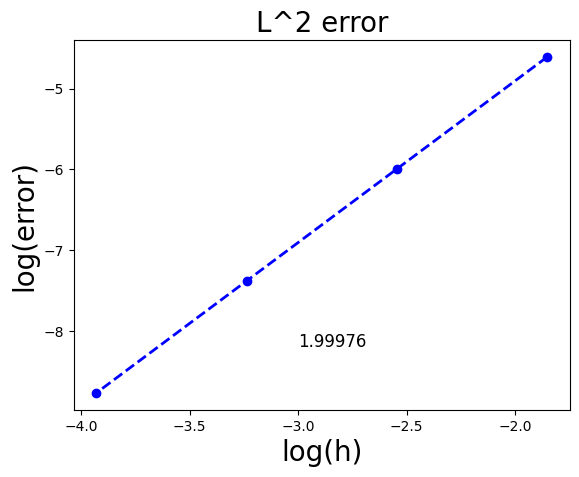

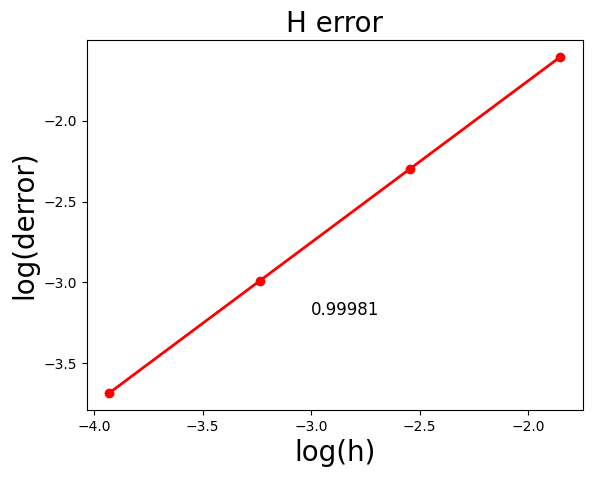

In [25]:
N_node,N_element,DOF,AE,L_element,L=function(5)
Ue,DUe,un=cal_err(L,DOF,AE)

# print(DUe)
x=Ue[:,0]
y_L=Ue[:,1]
y_H=DUe[:,1]
xx=np.log(x)
yy_L=np.log(y_L)
yy_H=np.log(y_H)
print((yy_L[3]-yy_L[0])/(xx[3]-xx[0]))
slope_L=np.polyfit(np.log(x),np.log(y_L),1)
slope_H=np.polyfit(np.log(x),np.log(y_H),1)
print(slope_L)
plt.figure(1)

plt.plot(xx,yy_L,'bo--',linewidth=2)
plt.title('L^2 error',fontsize=20)
plt.xlabel("log(h)",fontsize=20)
plt.ylabel("log(error)",fontsize=20)
ax=plt.gca()
# ax.xaxis.set_major_locator(MultipleLocator(0.05))
plt.text(-3,-8.2,np.round(slope_L.item(0),5),fontsize=12)
plt.autoscale()

plt.figure(2)

xd=x
yd=y_H
# print(un)
# xdd=np.matrix([xd[un-1],xd[un-2]])
# ydd=np.matrix([yd[un-1],yd[un-2]])
# xdd1=np.matrix([xd[un-2],xd[un-2]])
# ydd1=np.matrix([yd[un-2],yd[un-1]])
# xdd2=np.matrix([xd[un-2],xd[un-1]])
# ydd2=np.matrix([yd[un-1],yd[un-1]])
# print(ydd2)
# plt.plot(xdd,ydd,'k-',xdd1,ydd1,'k-',xdd2,ydd2,'k-',linewidth=1.5)
plt.plot(xx,yy_H,'ro-',linewidth=2)
plt.title('H error',fontsize=20)
plt.xlabel("log(h)",fontsize=20)
plt.ylabel("log(derror)",fontsize=20)
#ax=plt.gca()
#ax.xaxis.set_major_locator(MultipleLocator(0.05))
plt.text(-3,-3.2,np.round(slope_H.item(0),5),fontsize=12)
# plt.text(np.sqrt((xd[un-2]*xd[un-1])), yd[un-1]/1.2, '1', fontweight='bold', fontsize=12)
# plt.text(xd[un-2]*1.1,np.sqrt(yd[un-2]*y[un-1]),str(slope_H[0]),fontweight='bold',fontsize=12)
plt.autoscale()

# plt.figure(3)
# plt.plot(np.log(x),np.log(y_L),'r',lw=2)
# poly=np.poly1d(slope_L)
# # plt.plot(np.log(x),poly(np.log(x)),'b',lw=2)
plt.show()

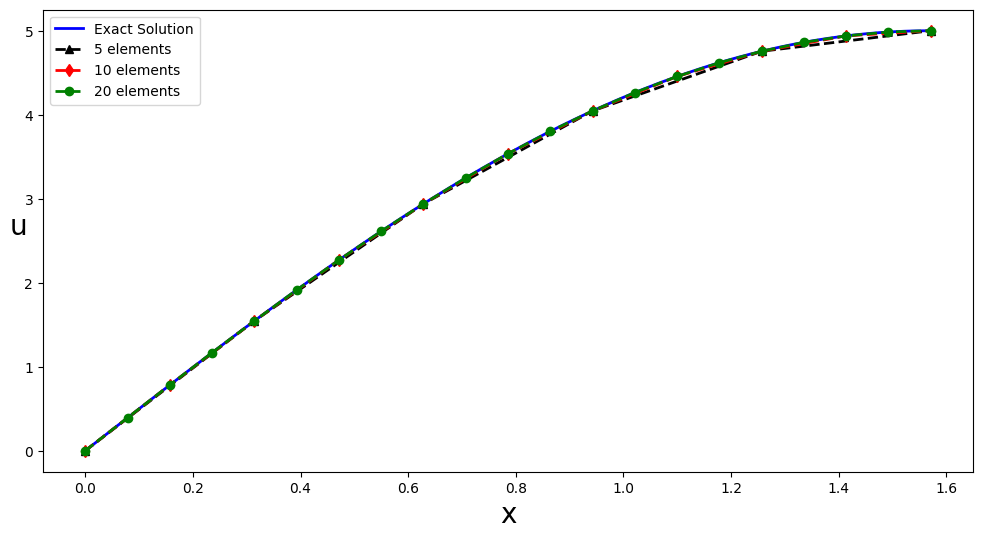

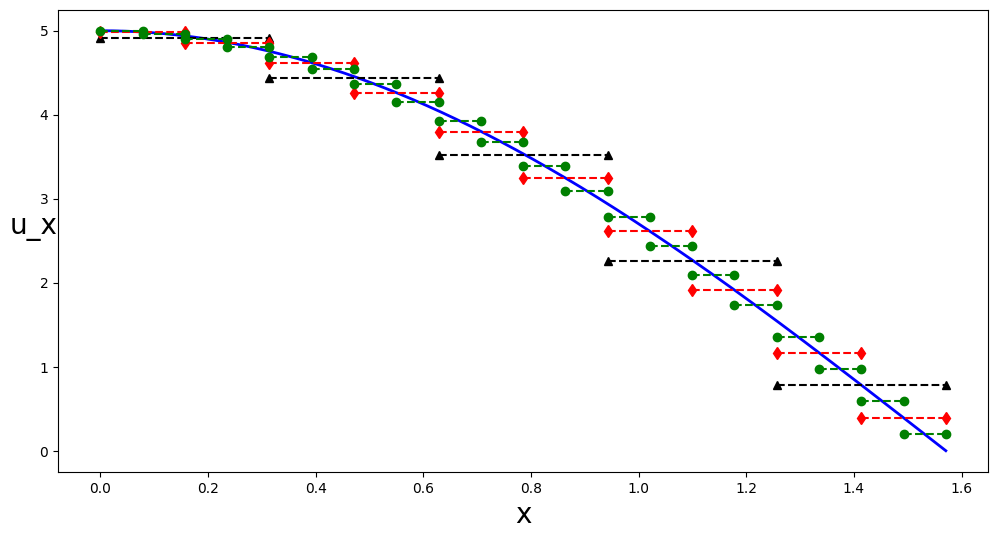

In [ ]:
N_node,N_element,DOF,AE,L_element,L=function(5)
x=np.linspace(0,L,1000)
#exact solution
u_exact=np.sin(x)/AE
dudx_exact=np.cos(x)/AE

N_node,N_element,DOF,AE,L_element,L=function(5)
#print(L_element)
u_x_5,du_dx_5=FEM(N_node,N_element,DOF,AE,L_element)

N_node,N_element,DOF,AE,L_element,L=function(10)
#print(L_element)
u_x_10,du_dx_10=FEM(N_node,N_element,DOF,AE,L_element)

N_node,N_element,DOF,AE,L_element,L=function(20)
#print(L_element)
u_x_20,du_dx_20=FEM(N_node,N_element,DOF,AE,L_element)

plt.figure(1,figsize=(12,6))
#print(L)
#print(len(u_exact))
#print(u_x_5)
plt.plot(np.linspace(0,L,len(u_exact)),u_exact,'b-',linewidth=2)
plt.plot(np.linspace(0,L,len(u_x_5)),u_x_5,'k^--',linewidth=2)
plt.plot(np.linspace(0,L,len(u_x_10)),u_x_10,'dr--',linewidth=2)
plt.plot(np.linspace(0,L,len(u_x_20)),u_x_20,'go--',linewidth=2)
plt.xlabel('x',fontsize=20)
plt.ylabel('u',fontsize=20,rotation=0)
plt.legend(['Exact Solution','5 elements','10 elements','20 elements'])
#
plt.figure(2,figsize=(12,6))
plt.plot(np.linspace(0,L,len(dudx_exact)),dudx_exact,'b-',linewidth=2)
for ele in range(5):
    L_element=L/5
    plt.plot([ele*L_element,(ele+1)*L_element],[du_dx_5[ele],du_dx_5[ele]],'k^--',linewidth=1.5)
for ele in range(10):
    L_element=L/10
    plt.plot([ele*L_element,(ele+1)*L_element],[du_dx_10[ele],du_dx_10[ele]],'dr--',linewidth=1.5)
for ele in range(20):
    L_element=L/20
    plt.plot([ele*L_element,(ele+1)*L_element],[du_dx_20[ele],du_dx_20[ele]],'go--',linewidth=1.5)
#plt.plot(np.linspace(0,L,len(du_dx_5)),du_dx_5,'k^--',linewidth=2)
#plt.plot(np.linspace(0,L,len(du_dx_10)),du_dx_10,'dr--',linewidth=2)
#plt.plot(np.linspace(0,L,len(du_dx_20)),du_dx_20,'go--',linewidth=2)
plt.xlabel('x',fontsize=20)
plt.ylabel('u_x',fontsize=20,rotation=0)
#plt.legend(['Exact Solution','5 elements','10 elements','20 elements'],handlelength=1.0)
#
# plt.figure(3,figsize=(12,6))
# plt.plot(np.linspace(0,L,len(dudx_exact)),dudx_exact,'b-',linewidth=2)
# for ele in range(5):
#     L_element=L/5
#     plt.plot((ele*L_element+(ele+1)*L_element)/2,du_dx_5[ele],'k^--',linewidth=1.5)

# for ele in range(10):
#     L_element=L/10
#     plt.plot((ele*L_element+(ele+1)*L_element)/2,du_dx_10[ele],'dr--',linewidth=1.5)
# for ele in range(20):
#     L_element=L/20
#     plt.plot((ele*L_element+(ele+1)*L_element)/2,du_dx_20[ele],'go--',linewidth=1.5)
# plt.xlabel('x',fontsize=20)
# plt.ylabel('u_x',fontsize=20,rotation=0)
#plt.legend()
#plt.legend(['Exact Solution','5 elements','10 elements','20 elements'])
#
plt.show()



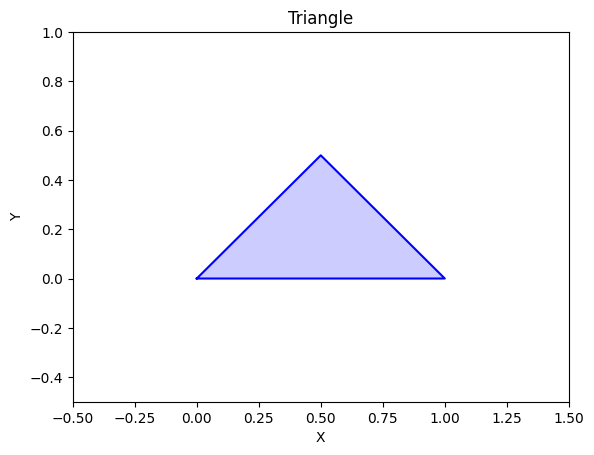

In [ ]:
import matplotlib.pyplot as plt

# 定义三个顶点的坐标
x = [0, 1, 0.5]
y = [0, 0, 0.5]

# 绘制三角形
plt.plot(x + [x[0]], y + [y[0]], 'b-')  # 通过连接顶点坐标来绘制三角形，最后一个点与第一个点相连
plt.fill(x, y, 'b', alpha=0.2)  # 填充三角形区域，使用alpha参数设置透明度

# 设置坐标轴范围
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1)

# 添加标题和坐标轴标签
plt.title('Triangle')
plt.xlabel('X')
plt.ylabel('Y')

# 显示图形
plt.show()


[ 1.89042531 -2.63987369  1.19480246]


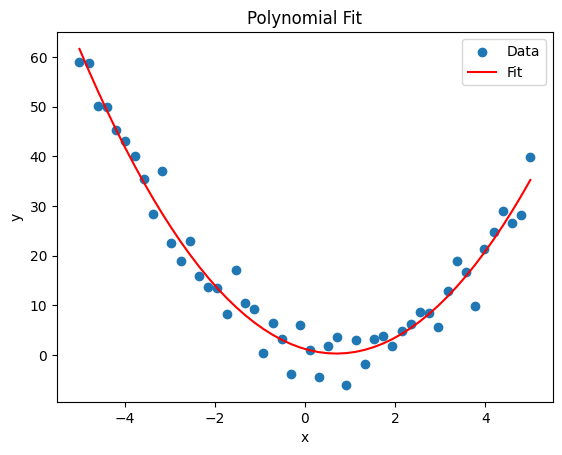

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 生成一些带噪声的数据点
x = np.linspace(-5, 5, 50)
y = 2 * x**2 - 3 * x + 1 + np.random.normal(0, 5, size=50)

# 进行二次多项式拟合
coefficients = np.polyfit(x, y, 2)
print(coefficients)
poly = np.poly1d(coefficients)  # 构建多项式对象

# 绘制原始数据点和拟合曲线
plt.scatter(x, y, label='Data')
plt.plot(x, poly(x), 'r', label='Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Polynomial Fit')
plt.show()
